In [2]:
from dolfin import *
from rbnics import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Poroelasticity(ParabolicCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        ParabolicCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        U = TrialFunction(V)
        (self.u, self.µ) = split(U)
        V_ = TestFunction(V)
        (self.v, self.q) = split(V_)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        self.µ_init = -0.3124
        self.µ_swell = -0.001
        self.alpha = 0.66  # value for robin boundary coefficient
        # Store the initial condition expression
        self.ic = project(InitialConditions(), self.V)

    # Return custom problem name
    def name(self):
        return "GelsMOR_nestedPOD_0426"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "m":
            theta_m0 = 1.
            return (theta_m0, )
        elif term == "a":
            theta_a0 = 2.
            theta_a1 = mu[0]
            theta_a2 = -mu[1]
            theta_a3 = 1.
            theta_a4 = self.alpha
            return (theta_a0, theta_a1, theta_a2, theta_a3,theta_a4,)
        elif term == "f":
            theta_f0 = self.alpha * self.µ_swell
            theta_f1 = -mu[1] * self.µ_init
            return (theta_f0,theta_f1,)
        elif term == "initial_condition":
            # Create intial conditions and interpolate
            u_init = 1.0
            theta_ic0 = u_init
            return (theta_ic0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        q = self.q
        dx = self.dx
        if term == "m":
            u = self.u
            m0 = tr( sym( grad(u)) )* q * dx
            return (m0,)
        elif term == "a":
            u = self.u
            µ = self.µ
            ds = self.ds
            alpha = self.alpha
            # sig = 2*sym(grad(u)) + ( lmbda*tr(sym(grad(u))) - A*(µ-µ_swell) )*Identity(mesh.topology().dim())
            # sig = self.elasticity(lmbda, A, u, µ)
            a0 = inner( sym(grad(u)), sym(grad(v)) ) * dx
            a1 = inner(tr(sym(grad(u))) * Identity(mesh.topology().dim()), sym(grad(v)) ) * dx
            a2 = inner(µ*Identity(mesh.topology().dim()), sym(grad(v)) ) * dx
            a3 = dot(grad(µ), grad(q)) * dx
            a4 = µ * q* ds(3) +  µ * q* ds(2)
            return (a0, a1, a2, a3, a4,)
        elif term == "f":
            ds = self.ds
            f0 = q * ds(2) + q * ds(3)
            f1 = inner( Identity(mesh.topology().dim()), sym(grad(v)) )*dx
            return (f0,f1,)
        elif term == "initial_condition":
            ic0 = self.ic
            return (ic0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V.sub(0).sub(1), Constant(0.0), self.boundaries, 4), DirichletBC(self.V.sub(0).sub(0), Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            µ = self.µ
            x0 = inner(u, v) * dx +  inner(µ,q)*dx
            return (x0,)
        elif term == "projection_inner_product":
            u = self.u
            µ = self.µ
            x0 = inner(u, v) * dx +  inner(µ,q)*dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")
        
# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = -0.3124        # mu
    def value_shape(self):
        return (3,)

In [4]:
# Model setup
L = 1  # Thickness of the plate
N = 50  # mesh density
mesh = UnitSquareMesh(N,N)

n = FacetNormal(mesh)
# Define boundary conditions
class Left(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], 0)
class Right(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], L)
class Top(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], L)
class Bottom(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], 0)

# Add boundaries
left = Left()
right = Right()
top = Top()
bottom = Bottom()
subdomains = MeshFunction("size_t", mesh,  mesh.topology().dim(), 0)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
top.mark(boundaries,3)
bottom.mark(boundaries,4)

In [6]:
### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_µ = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
V = FunctionSpace(mesh, MixedElement([element_u, element_µ]))

In [7]:
problem = Poroelasticity(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(1000, 2000), (2000, 6000),]
problem.set_mu_range(mu_range)
problem.set_time_step_size(0.0025)
problem.set_final_time(0.25)

###  Prepare reduction with a POD-Galerkin method

In [8]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20, nested_POD=6)
# reduction_method.set_tolerance(1e-8)

### Perform the offline phase

In [9]:
reduction_method.initialize_training_set(30)
reduced_problem = reduction_method.offline()

### Perform an online solve

In [10]:
online_mu = (1558, 4000)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()

In [11]:
time_instance = 100
reduced_solution_at_time_instance = reduced_solution[time_instance]  # this is OnlineVector
type( reduced_solution_at_time_instance )


rbnics.backends.online.basic.function.Function.<locals>._Function_Type

In [12]:
reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:reduced_solution_at_time_instance.N] * reduced_solution_at_time_instance  # this is a dolfin Function
type( reconstructed_reduced_solution_at_time_instance )
( u_time,µ_time ) = split(reconstructed_reduced_solution_at_time_instance)

### Perform convergence error analysis with testing samples

In [17]:
# import os

# # Define the directory to save the figures
# save_dir = "results/ROM/time/"  # Replace with your desired path

# # Check if the directory exists, if not, create it
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# # Form compiler options
# parameters["form_compiler"]["optimize"]     = True
# parameters["form_compiler"]["cpp_optimize"] = True

# # Model setup
# L = 1  # Thickness of the plate
# N = 50  # mesh density
# mesh = UnitSquareMesh(N,N)

# n = FacetNormal(mesh)


# # Define boundary conditions
# class Left(SubDomain):
#     def inside(self,x, on_boundary):
#         return on_boundary and near(x[0], 0)
# class Right(SubDomain):
#     def inside(self,x, on_boundary):
#         return on_boundary and near(x[0], L)
# class Top(SubDomain):
#     def inside(self,x, on_boundary):
#         return on_boundary and near(x[1], L)
# class Bottom(SubDomain):
#     def inside(self,x, on_boundary):
#         return on_boundary and near(x[1], 0)

# # Add boundaries
# left = Left()
# right = Right()
# top = Top()
# bottom = Bottom()

# boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
# left.mark(boundaries, 1)
# right.mark(boundaries, 2)
# top.mark(boundaries,3)
# bottom.mark(boundaries,4)

# ### Field variable function spaces
# element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
# element_µ = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
# V = FunctionSpace(mesh, MixedElement([element_u, element_µ]))

# # Parameters Normalised
# µ_init = -0.3124 # initial chemical potential

# # zero displacement boundary conditions on the symmetric part of the plate
# u_bc_bottom = DirichletBC(V.sub(0).sub(1), Constant(0.0), bottom) 
# u_bc_left = DirichletBC(V.sub(0).sub(0), Constant(0.0), left)
# µ_swell = -0.001
# bcs = [u_bc_bottom, u_bc_left] 

# # Class representing the intial conditions
# class InitialConditions(UserExpression):
#     def eval(self, values, x):
#         values[0] = 0.0                 # ux
#         values[1] = 0.0                 # uy
#         values[2] = µ_init #-0.3124        # mu
#     def value_shape(self):
#         return (3,)
    
    
# dU = TrialFunction(V)
# (du, dµ) = split(dU)
# V_ = TestFunction(V)
# (v, q) = split(V_)
# Uold = Function(V)
# (uold, µold) = split(Uold)
# U = Function(V)
# (u, µ) = split(U)

# # A = 4000
# # lmbda = 1558
# alpha = 0.66 # robin bcs

# parameter_list = [
#     (1831.4166388008757, 4918.531249749167),
#     (1263.089574701949, 5387.959928737897),
#     (1648.2093876840263, 5534.493822541461),
#     (1154.6464665721596, 2852.2694707870023),
#     (1204.4205292602867, 5985.725448883642),
#     (1662.1198563210344, 5297.31897838799),
#     (1160.1210585452582, 5057.123359111345),
#     (1230.0521902177218, 2275.024660567834),
#     (1552.6745372591959, 5904.726958837215),
#     (1972.2709821571375, 3599.0212164232844)
# ]

# # # Error results storage
# # absolute_errors_µ = []
# # relative_errors_µ = []
# # absolute_errors_displacement = []
# # relative_errors_displacement = []

# # Range of basis function counts
# basis_counts = range(1, 9)

# # Error results storage
# absolute_errors_µ = {n: [] for n in basis_counts}
# relative_errors_µ = {n: [] for n in basis_counts}
# absolute_errors_displacement = {n: [] for n in basis_counts}
# relative_errors_displacement = {n: [] for n in basis_counts}

# absolute_errors_displacement_x = {n: [] for n in basis_counts}
# relative_errors_displacement_x = {n: [] for n in basis_counts}
# absolute_errors_displacement_y = {n: [] for n in basis_counts}
# relative_errors_displacement_y = {n: [] for n in basis_counts}

# absolute_errors_displacement_L2= {n: [] for n in basis_counts}
# absolute_errors_displacement_L1= {n: [] for n in basis_counts}
# absolute_errors_displacement_Linf= {n: [] for n in basis_counts}

# absolute_errors_displacement_x_L2= {n: [] for n in basis_counts}
# absolute_errors_displacement_x_L1= {n: [] for n in basis_counts}
# absolute_errors_displacement_x_Linf= {n: [] for n in basis_counts}

# absolute_errors_displacement_y_L2= {n: [] for n in basis_counts}
# absolute_errors_displacement_y_L1= {n: [] for n in basis_counts}
# absolute_errors_displacement_y_Linf= {n: [] for n in basis_counts}

# absolute_errors_µ_L2= {n: [] for n in basis_counts}
# absolute_errors_µ_L1= {n: [] for n in basis_counts}
# absolute_errors_µ_Linf= {n: [] for n in basis_counts}

# # Main simulation block
# for lmbda, A in parameter_list:
#     print("Running simulation with lambda =", lmbda, "and A =", A)

#     # Create intial conditions and interpolate
#     u_init = InitialConditions()
#     Uold.interpolate(u_init)

#     # Strain
#     def eps(u):
#         return sym( grad(u) )
#     # Stress 
#     def sigma(u, µ):
#         return 2*eps(u) + ( lmbda*tr(eps(u)) - A*(µ-µ_init) )*Identity(mesh.topology().dim())

#     dt = Constant(0.)
#     ds = Measure('ds', subdomain_data=boundaries)

#     mech_form = inner( sigma(du, dµ),eps(v))*dx
#     chem_form = ( tr( eps(du)-eps(uold) )/dt )*q*dx + dot(grad(dµ),grad(q))*dx +  Constant(alpha)*(dµ-µ_swell)*q*ds(2) + Constant(alpha)*(dµ-µ_swell)*q*ds(3)
#     form = mech_form + chem_form

#     Nincr = 100
#     t = np.linspace(0, 0.25, Nincr+1)
#     Nx = 100
#     x = np.linspace(0, L, Nx)

#     # S = FunctionSpace(mesh, element_µ)
#     S = U.function_space()
    
#     # Initialize arrays for ROM results
#     u1_low = np.zeros((Nincr+1, ))
#     u2_low = np.zeros((Nincr+1, ))
#     µ_low = np.zeros((Nincr+1, ))
#     µ_low[0] = µ_init
#     u1_low[0], u2_low[0] = 0, 0
    
#      # Time-stepping loop
#     for (i, dti) in enumerate(np.diff(t)):
#         print("Increment " + str(i + 1))
#         t_current = t[i + 1]
#         # FOM: Solve the full problem at this time step
#         dt.assign(dti)  # Assuming dt is a FEniCS Constant or similar
#         solve(lhs(form) == rhs(form), U, bcs)  # Solve using FEniCS
#         Uold.assign(U)
#         (u, µ) = split(U)
        
#         displacement_magnitude = sqrt(inner(u, u))
#         dips_mag_FOM = project(displacement_magnitude, S.sub(1).collapse())
#         delta = 1e-8  # You can adjust this value based on the application
#         denominator = np.maximum(np.abs(dips_mag_FOM.vector()[:]), delta)

#         reduced_problem.set_mu((lmbda, A))
#         reduced_solution = reduced_problem.solve()

#         for n in basis_counts:
#             # ROM: Solve the reduced problem with `n` basis functions
#             reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:n] * reduced_solution[i]
#             (u_time, µ_time) = split(reconstructed_reduced_solution_at_time_instance)

#             # Create functions for the µ components
#             µ_full_func = Function(S.sub(1).collapse())
#             µ_reduced_func = project(µ_time, S.sub(1).collapse())

#             # Assign the components to these functions
#             assign(µ_full_func, U.sub(1))

#             # Compute absolute error for the µ component
#             error_µ_abs = Function(S.sub(1).collapse())
#             error_µ_abs.vector()[:] = abs(µ_full_func.vector()[:] - µ_reduced_func.vector()[:])

#             # Compute relative error for the µ component
#             epsilon = 1e-12
#             error_µ_rel = Function(S.sub(1).collapse())
#             error_µ_rel.vector()[:] = abs(µ_full_func.vector()[:] - µ_reduced_func.vector()[:]) / (abs(µ_full_func.vector()[:]) + epsilon)

#             # Compute norm-based errors for µ component
#             error_µ_L2 = norm(error_µ_abs, 'L2')
#             error_µ_L1 = assemble(abs(µ_full_func - µ_reduced_func) * dx)
#             error_µ_Linf = np.max(error_µ_abs.vector().get_local())

#             # Compute displacement magnitudes
#             displacement_magnitude_MOR = sqrt(inner(u_time, u_time))
#             dips_mag_MOR = project(displacement_magnitude_MOR, S.sub(1).collapse())

#             # Compute absolute error for displacement magnitude
#             error_u_abs = Function(S.sub(1).collapse())
#             error_u_abs.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])

#             # Compute relative error for displacement magnitude
#             error_u_rel = Function(S.sub(1).collapse())
#             error_u_rel.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:]) / denominator

#             # Compute norm-based errors for displacement magnitude
#             error_u_L2 = norm(error_u_abs, 'L2')
#             error_u_L1 = assemble(abs(dips_mag_FOM - dips_mag_MOR) * dx)
#             error_u_Linf = np.max(error_u_abs.vector().get_local())

#             # Compute absolute and relative errors for the x component of displacement
#             u1_FOM = project(u[0], S.sub(1).collapse())
#             u1_MOR = project(u_time[0], S.sub(1).collapse())

#             error_u1_abs = Function(S.sub(1).collapse())
#             error_u1_abs.vector()[:] = abs(u1_FOM.vector()[:] - u1_MOR.vector()[:])

#             denominator_u1 = np.maximum(np.abs(u1_FOM.vector()[:]), delta)
#             error_u1_rel = Function(S.sub(1).collapse())
#             error_u1_rel.vector()[:] = abs(u1_FOM.vector()[:] - u1_MOR.vector()[:]) / denominator_u1

#             error_u1_L2 = norm(error_u1_abs, 'L2')
#             error_u1_L1 = assemble(abs(u1_FOM - u1_MOR) * dx)
#             error_u1_Linf = np.max(error_u1_abs.vector().get_local())

#             # Compute absolute and relative errors for the y component of displacement
#             u2_FOM = project(u[1], S.sub(1).collapse())
#             u2_MOR = project(u_time[1], S.sub(1).collapse())

#             error_u2_abs = Function(S.sub(1).collapse())
#             error_u2_abs.vector()[:] = abs(u2_FOM.vector()[:] - u2_MOR.vector()[:])

#             denominator_u2 = np.maximum(np.abs(u2_FOM.vector()[:]), delta)
#             error_u2_rel = Function(S.sub(1).collapse())
#             error_u2_rel.vector()[:] = abs(u2_FOM.vector()[:] - u2_MOR.vector()[:]) / denominator_u2

#             error_u2_L2 = norm(error_u2_abs, 'L2')
#             error_u2_L1 = assemble(abs(u2_FOM - u2_MOR) * dx)
#             error_u2_Linf = np.max(error_u2_abs.vector().get_local())

#             # Append errors to storage
#             absolute_errors_µ[n].append(np.max(error_µ_abs.vector()[:]))
#             relative_errors_µ[n].append(np.max(error_µ_rel.vector()[:]))
#             absolute_errors_displacement[n].append(np.max(error_u_abs.vector()[:]))
#             relative_errors_displacement[n].append(np.max(error_u_rel.vector()[:]))

#             absolute_errors_displacement_x[n].append(np.max(error_u1_abs.vector()[:]))
#             relative_errors_displacement_x[n].append(np.max(error_u1_rel.vector()[:]))
#             absolute_errors_displacement_y[n].append(np.max(error_u2_abs.vector()[:]))
#             relative_errors_displacement_y[n].append(np.max(error_u2_rel.vector()[:]))

#             absolute_errors_displacement_L2[n].append(error_u_L2)
#             absolute_errors_displacement_L1[n].append(error_u_L1)
#             absolute_errors_displacement_Linf[n].append(error_u_Linf)

#             absolute_errors_displacement_x_L2[n].append(error_u1_L2)
#             absolute_errors_displacement_x_L1[n].append(error_u1_L1)
#             absolute_errors_displacement_x_Linf[n].append(error_u1_Linf)

#             absolute_errors_displacement_y_L2[n].append(error_u2_L2)
#             absolute_errors_displacement_y_L1[n].append(error_u2_L1)
#             absolute_errors_displacement_y_Linf[n].append(error_u2_Linf)

#             absolute_errors_µ_L2[n].append(error_µ_L2)
#             absolute_errors_µ_L1[n].append(error_µ_L1)
#             absolute_errors_µ_Linf[n].append(error_µ_Linf)

        
#         # displacement_magnitude = sqrt(inner(u, u))
#         # dips_mag_FOM = project(displacement_magnitude, S.sub(1).collapse())
#         # delta = 1e-8  # You can adjust this value based on the application
#         # denominator = np.maximum(np.abs(dips_mag_FOM.vector()[:]), delta)

#         # reduced_problem.set_mu((lmbda, A))
#         # reduced_solution = reduced_problem.solve()

#         # for n in basis_counts:
#         #     # ROM: Solve the reduced problem with `n` basis functions
#         #     reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:n] * reduced_solution[i]
#         #     (u_time, µ_time) = split(reconstructed_reduced_solution_at_time_instance)

#         #     # Create functions for the µ components
#         #     µ_full_func = Function(S.sub(1).collapse())
#         #     µ_reduced_func = project(µ_time, S.sub(1).collapse())

#         #     # Assign the components to these functions
#         #     assign(µ_full_func, U.sub(1))

#         #     # Compute absolute error for the µ component
#         #     error_µ_abs = Function(S.sub(1).collapse())
#         #     error_µ_abs.vector()[:] = abs(µ_full_func.vector()[:] - µ_reduced_func.vector()[:])

#         #     # Compute relative error for the µ component
#         #     epsilon = 1e-12
#         #     error_µ_rel = Function(S.sub(1).collapse())
#         #     error_µ_rel.vector()[:] = abs(µ_full_func.vector()[:] - µ_reduced_func.vector()[:]) / (abs(µ_full_func.vector()[:]) + epsilon)

#         #     # Compute displacement magnitudes
#         #     displacement_magnitude_MOR = sqrt(inner(u_time, u_time))

#         #     dips_mag_MOR = project(displacement_magnitude_MOR, S.sub(1).collapse())

#         #     # Compute absolute error for displacement magnitude
#         #     error_u_abs = Function(S.sub(1).collapse())
#         #     error_u_abs.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])

#         #     # Compute relative error for displacement magnitude
#         #     # error_u_rel = Function(S.sub(1).collapse())
#         #     # error_u_rel.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:]) / (abs(dips_mag_FOM.vector()[:] + epsilon))

#         #     error_u_rel = Function(S.sub(1).collapse())
#         #     error_u_rel.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:]) / denominator

#         #     # Append errors to storage
#         #     absolute_errors_µ[n].append(np.max(error_µ_abs.vector()[:]))
#         #     relative_errors_µ[n].append(np.max(error_µ_rel.vector()[:]))
#         #     absolute_errors_displacement[n].append(np.max(error_u_abs.vector()[:]))
#         #     relative_errors_displacement[n].append(np.max(error_u_rel.vector()[:]))

#             # # Compute absolute and relative errors for the x component of displacement
#             # u1_FOM = project(u[0], S.sub(1).collapse())
#             # u1_MOR = project(u_time[0], S.sub(1).collapse())

#             # error_u1_abs = Function(S.sub(1).collapse())
#             # error_u1_abs.vector()[:] = abs(u1_FOM.vector()[:] - u1_MOR.vector()[:])

#             # denominator_u1 = np.maximum(np.abs(u1_FOM.vector()[:]), delta)
#             # error_u1_rel = Function(S.sub(1).collapse())
#             # error_u1_rel.vector()[:] = abs(u1_FOM.vector()[:] - u1_MOR.vector()[:]) / denominator_u1

#             # # Compute absolute and relative errors for the y component of displacement
#             # u2_FOM = project(u[1], S.sub(1).collapse())
#             # u2_MOR = project(u_time[1], S.sub(1).collapse())

#             # error_u2_abs = Function(S.sub(1).collapse())
#             # error_u2_abs.vector()[:] = abs(u2_FOM.vector()[:] - u2_MOR.vector()[:])

#             # denominator_u2 = np.maximum(np.abs(u2_FOM.vector()[:]), delta)
#             # error_u2_rel = Function(S.sub(1).collapse())
#             # error_u2_rel.vector()[:] = abs(u2_FOM.vector()[:] - u2_MOR.vector()[:]) / denominator_u2

#             # # Append errors to storage
#             # absolute_errors_displacement_x[n].append(np.max(error_u1_abs.vector()[:]))
#             # relative_errors_displacement_x[n].append(np.max(error_u1_rel.vector()[:]))
#             # absolute_errors_displacement_y[n].append(np.max(error_u2_abs.vector()[:]))
#             # relative_errors_displacement_y[n].append(np.max(error_u2_rel.vector()[:]))

In [18]:
# import csv

# # Compute mean and max norm-based errors for each basis count
# mean_absolute_errors_µ = {n: np.mean(absolute_errors_µ[n]) for n in basis_counts}
# mean_relative_errors_µ = {n: np.mean(relative_errors_µ[n]) for n in basis_counts}
# mean_absolute_errors_displacement = {n: np.mean(absolute_errors_displacement[n]) for n in basis_counts}
# mean_relative_errors_displacement = {n: np.mean(relative_errors_displacement[n]) for n in basis_counts}
# mean_absolute_errors_displacement_x = {n: np.mean(absolute_errors_displacement_x[n]) for n in basis_counts}
# mean_relative_errors_displacement_x = {n: np.mean(relative_errors_displacement_x[n]) for n in basis_counts}
# mean_absolute_errors_displacement_y = {n: np.mean(absolute_errors_displacement_y[n]) for n in basis_counts}
# mean_relative_errors_displacement_y = {n: np.mean(relative_errors_displacement_y[n]) for n in basis_counts}
# mean_absolute_errors_displacement_L2 = {n: np.mean(absolute_errors_displacement_L2[n]) for n in basis_counts}
# mean_absolute_errors_displacement_L1 = {n: np.mean(absolute_errors_displacement_L1[n]) for n in basis_counts}
# mean_absolute_errors_displacement_Linf = {n: np.mean(absolute_errors_displacement_Linf[n]) for n in basis_counts}
# mean_absolute_errors_displacement_x_L2 = {n: np.mean(absolute_errors_displacement_x_L2[n]) for n in basis_counts}
# mean_absolute_errors_displacement_x_L1 = {n: np.mean(absolute_errors_displacement_x_L1[n]) for n in basis_counts}
# mean_absolute_errors_displacement_x_Linf = {n: np.mean(absolute_errors_displacement_x_Linf[n]) for n in basis_counts}
# mean_absolute_errors_displacement_y_L2 = {n: np.mean(absolute_errors_displacement_y_L2[n]) for n in basis_counts}
# mean_absolute_errors_displacement_y_L1 = {n: np.mean(absolute_errors_displacement_y_L1[n]) for n in basis_counts}
# mean_absolute_errors_displacement_y_Linf = {n: np.mean(absolute_errors_displacement_y_Linf[n]) for n in basis_counts}
# mean_absolute_errors_µ_L2 = {n: np.mean(absolute_errors_µ_L2[n]) for n in basis_counts}
# mean_absolute_errors_µ_L1 = {n: np.mean(absolute_errors_µ_L1[n]) for n in basis_counts}
# mean_absolute_errors_µ_Linf = {n: np.mean(absolute_errors_µ_Linf[n]) for n in basis_counts}

# overall_max_errors_µ = {n: np.max(absolute_errors_µ[n]) for n in basis_counts}
# overall_max_relative_errors_µ = {n: np.max(relative_errors_µ[n]) for n in basis_counts}
# overall_max_errors_displacement = {n: np.max(absolute_errors_displacement[n]) for n in basis_counts}
# overall_max_relative_errors_displacement = {n: np.max(relative_errors_displacement[n]) for n in basis_counts}
# overall_max_errors_displacement_x = {n: np.max(absolute_errors_displacement_x[n]) for n in basis_counts}
# overall_max_relative_errors_displacement_x = {n: np.max(relative_errors_displacement_x[n]) for n in basis_counts}
# overall_max_errors_displacement_y = {n: np.max(absolute_errors_displacement_y[n]) for n in basis_counts}
# overall_max_relative_errors_displacement_y = {n: np.max(relative_errors_displacement_y[n]) for n in basis_counts}
# overall_max_errors_displacement_L2 = {n: np.max(absolute_errors_displacement_L2[n]) for n in basis_counts}
# overall_max_errors_displacement_L1 = {n: np.max(absolute_errors_displacement_L1[n]) for n in basis_counts}
# overall_max_errors_displacement_Linf = {n: np.max(absolute_errors_displacement_Linf[n]) for n in basis_counts}
# overall_max_errors_displacement_x_L2 = {n: np.max(absolute_errors_displacement_x_L2[n]) for n in basis_counts}
# overall_max_errors_displacement_x_L1 = {n: np.max(absolute_errors_displacement_x_L1[n]) for n in basis_counts}
# overall_max_errors_displacement_x_Linf = {n: np.max(absolute_errors_displacement_x_Linf[n]) for n in basis_counts}
# overall_max_errors_displacement_y_L2 = {n: np.max(absolute_errors_displacement_y_L2[n]) for n in basis_counts}
# overall_max_errors_displacement_y_L1 = {n: np.max(absolute_errors_displacement_y_L1[n]) for n in basis_counts}
# overall_max_errors_displacement_y_Linf = {n: np.max(absolute_errors_displacement_y_Linf[n]) for n in basis_counts}
# overall_max_errors_µ_L2 = {n: np.max(absolute_errors_µ_L2[n]) for n in basis_counts}
# overall_max_errors_µ_L1 = {n: np.max(absolute_errors_µ_L1[n]) for n in basis_counts}
# overall_max_errors_µ_Linf = {n: np.max(absolute_errors_µ_Linf[n]) for n in basis_counts}

# # Print final results processing
# print("Mean Absolute µ Errors:", mean_absolute_errors_µ)
# print("Mean Relative µ Errors:", mean_relative_errors_µ)
# print("Mean Absolute Displacement Errors:", mean_absolute_errors_displacement)
# print("Mean Relative Displacement Errors:", mean_relative_errors_displacement)

# print("Overall Max Absolute µ Errors:", overall_max_errors_µ)
# print("Overall Max Relative µ Errors:", overall_max_relative_errors_µ)
# print("Overall Max Absolute Displacement Errors:", overall_max_errors_displacement)
# print("Overall Max Relative Displacement Errors:", overall_max_relative_errors_displacement)

# # Save errors to a CSV file
# csv_file_path = "norm_based_errors_summary_nestedPOD_20240509.csv"

# with open(csv_file_path, mode='w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow([
#         'N', #'mean(abs_error_µ)', 'max(abs_error_µ)', 'mean(rel_error_µ)', 'max(rel_error_µ)',
#         #'mean(abs_error_disp)', 'max(abs_error_disp)', 'mean(rel_error_disp)', 'max(rel_error_disp)',
#         #'mean(abs_error_disp_x)', 'max(abs_error_disp_x)', 'mean(rel_error_disp_x)', 'max(rel_error_disp_x)',
#         #'mean(abs_error_disp_y)', 'max(abs_error_disp_y)', 'mean(rel_error_disp_y)', 'max(rel_error_disp_y)',
#         'mean(L2_error_disp)', 'max(L2_error_disp)', 'mean(L1_error_disp)', 'max(L1_error_disp)', 'mean(Linf_error_disp)', 'max(Linf_error_disp)',
#         #'mean(L2_error_disp_x)', 'max(L2_error_disp_x)', 'mean(L1_error_disp_x)', 'max(L1_error_disp_x)', 'mean(Linf_error_disp_x)', 'max(Linf_error_disp_x)',
#         #'mean(L2_error_disp_y)', 'max(L2_error_disp_y)', 'mean(L1_error_disp_y)', 'max(L1_error_disp_y)', 'mean(Linf_error_disp_y)', 'max(Linf_error_disp_y)',
#         'mean(L2_error_µ)', 'max(L2_error_µ)', 'mean(L1_error_µ)', 'max(L1_error_µ)', 'mean(Linf_error_µ)', 'max(Linf_error_µ)'
#     ])
#     for n in basis_counts:
#         writer.writerow([
#             n,
#             # mean_absolute_errors_µ[n], overall_max_errors_µ[n], mean_relative_errors_µ[n], overall_max_relative_errors_µ[n],
#             # mean_absolute_errors_displacement[n], overall_max_errors_displacement[n], mean_relative_errors_displacement[n], overall_max_relative_errors_displacement[n],
#             # mean_absolute_errors_displacement_x[n], overall_max_errors_displacement_x[n], mean_relative_errors_displacement_x[n], overall_max_relative_errors_displacement_x[n],
#             # mean_absolute_errors_displacement_y[n], overall_max_errors_displacement_y[n], mean_relative_errors_displacement_y[n], overall_max_relative_errors_displacement_y[n],
#             mean_absolute_errors_displacement_L2[n], overall_max_errors_displacement_L2[n], mean_absolute_errors_displacement_L1[n], overall_max_errors_displacement_L1[n], mean_absolute_errors_displacement_Linf[n], overall_max_errors_displacement_Linf[n],
#             # mean_absolute_errors_displacement_x_L2[n], overall_max_errors_displacement_x_L2[n], mean_absolute_errors_displacement_x_L1[n], overall_max_errors_displacement_x_L1[n], mean_absolute_errors_displacement_x_Linf[n], overall_max_errors_displacement_x_Linf[n],
#             # mean_absolute_errors_displacement_y_L2[n], overall_max_errors_displacement_y_L2[n], mean_absolute_errors_displacement_y_L1[n], overall_max_errors_displacement_y_L1[n], mean_absolute_errors_displacement_y_Linf[n], overall_max_errors_displacement_y_Linf[n],
#             mean_absolute_errors_µ_L2[n], overall_max_errors_µ_L2[n], mean_absolute_errors_µ_L1[n], overall_max_errors_µ_L1[n], mean_absolute_errors_µ_Linf[n], overall_max_errors_µ_Linf[n]
#         ])

# print(f"Results saved to {csv_file_path}")

In [19]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

# Model setup
L = 1  # Thickness of the plate
N = 50  # mesh density
mesh = UnitSquareMesh(N,N)

n = FacetNormal(mesh)


# Define boundary conditions
class Left(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], 0)
class Right(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[0], L)
class Top(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], L)
class Bottom(SubDomain):
    def inside(self,x, on_boundary):
        return on_boundary and near(x[1], 0)

# Add boundaries
left = Left()
right = Right()
top = Top()
bottom = Bottom()

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
top.mark(boundaries,3)
bottom.mark(boundaries,4)

### Field variable function spaces
element_u = VectorElement('CG', mesh.ufl_cell(), 2) # displacement finite element
element_µ = FiniteElement('CG', mesh.ufl_cell(), 1) # chemical potential finite element
V = FunctionSpace(mesh, MixedElement([element_u, element_µ]))

# Parameters Normalised
µ_init = -0.3124 # initial chemical potential
A = 4000
lmbda = 1558
alpha = 0.66 # robin bcs

# zero displacement boundary conditions on the symmetric part of the plate
u_bc_bottom = DirichletBC(V.sub(0).sub(1), Constant(0.0), bottom) 
u_bc_left = DirichletBC(V.sub(0).sub(0), Constant(0.0), left)
µ_swell = -0.001
bcs = [u_bc_bottom, u_bc_left] 

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def eval(self, values, x):
        values[0] = 0.0                 # ux
        values[1] = 0.0                 # uy
        values[2] = µ_init #-0.3124        # mu
    def value_shape(self):
        return (3,)
    
    
dU = TrialFunction(V)
(du, dµ) = split(dU)
V_ = TestFunction(V)
(v, q) = split(V_)
Uold = Function(V)
(uold, µold) = split(Uold)
U = Function(V)
(u, µ) = split(U)

# Create intial conditions and interpolate
u_init = InitialConditions()
Uold.interpolate(u_init)

# Strain
def eps(u):
    return sym( grad(u) )
# Stress 
def sigma(u, µ):
    return 2*eps(u) + ( lmbda*tr(eps(u)) - A*(µ-µ_init) )*Identity(mesh.topology().dim())

dt = Constant(0.)
ds = Measure('ds', subdomain_data=boundaries)

mech_form = inner( sigma(du, dµ),eps(v))*dx
chem_form = ( tr( eps(du)-eps(uold) )/dt )*q*dx + dot(grad(dµ),grad(q))*dx +  Constant(alpha)*(dµ-µ_swell)*q*ds(2) + Constant(alpha)*(dµ-µ_swell)*q*ds(3)
form = mech_form + chem_form

In [21]:
import os

# Define the directory to save the figures
save_dir = "results/ROM/time/"  # Replace with your desired path

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Nincr = 100
t = np.linspace(0, 0.25, Nincr+1)
Nx = 100
x = np.linspace(0, L, Nx)

# S = FunctionSpace(mesh, element_µ)
S = U.function_space()

uFOM_time = []
uFOMx_time = []
uFOMy_time = []
µFOM_time = []

uROM_time = []
uROMx_time = []
uROMy_time = []
µROM_time = []

# Initialize arrays for FOM results
Sigyy = np.zeros((Nincr+1, ))
Epsyy = np.zeros((Nincr+1, ))
u1_res = np.zeros((Nincr+1, ))
u2_res = np.zeros((Nincr+1, ))
µ_res = np.zeros((Nincr+1, ))
res = np.zeros((Nx, Nincr+1))
µ_res[0] = µ_init
u1_res[0], u2_res[0] = 0, 0

# Initialize arrays for ROM results
u1_low = np.zeros((Nincr+1, ))
u2_low = np.zeros((Nincr+1, ))
µ_low = np.zeros((Nincr+1, ))
µ_low[0] = µ_init
u1_low[0], u2_low[0] = 0, 0

# Define fixed color scale range
import matplotlib.colors as mcolors
vmin = 0.0
vmax = 0.08
cbar_ticks = np.linspace(vmin, vmax, num=5)
# Create a Normalize object for the color scale
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Time-stepping loop
for (i, dti) in enumerate(np.diff(t)):
    print("Increment " + str(i+1))
    t_current = t[i+1]
    # FOM: Solve the full problem at this time step
    dt.assign(dti)  # Assuming dt is a FEniCS Constant or similar
    solve(lhs(form) == rhs(form), U, bcs)  # Solve using FEniCS
    Uold.assign(U)
    (u, µ) = split(U)
    
    # u is stored at each time step
    uFOM_time.append(u)
    uFOMx_time.append(project(u[0], S.sub(1).collapse()))
    uFOMy_time.append(project(u[1], S.sub(1).collapse()))
    
    µFOM_time.append(project(µ,S.sub(1).collapse()))
    
    res[:, i+1] = [U(xi, 0.0)[2] for xi in x]
    # get average stress/strain
    Sigyy[i+1] = assemble(sigma(u, µ)[1, 1]*dx)
    #episoln = eps(u)(0,0)[1, 1]
    Epsyy[i+1] = assemble(eps(u)[1, 1]*dx)
    µ_res[i+1] = assemble(µ*dx)
    u1_res[i+1] =  assemble(u[0]*dx)
    u2_res[i+1] =  assemble(u[1]*dx)

    # ROM: Solve the reduced problem at this time step
    time_instance = i
    reduced_solution_at_time_instance = reduced_solution[time_instance]
    reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions[:reduced_solution_at_time_instance.N] * reduced_solution_at_time_instance
    (u_time, µ_time) = split(reconstructed_reduced_solution_at_time_instance)
    
    uROM_time.append(u_time)
    uROMx_time.append(project(u_time[0], S.sub(1).collapse()))
    uROMy_time.append(project(u_time[1], S.sub(1).collapse()))
    
    µROM_time.append(project(µ_time,S.sub(1).collapse()))
    
    u1_low[i+1] = assemble( u_time[0]*dx )
    u2_low[i+1] = assemble( u_time[1]*dx )
    µ_low[i+1] = assemble(µ_time*dx)
    
    # Plot every N iterations
    if i == 1 or i == 14 or i == 24 or i == 49 or i == 99: #(i+1) % 20 == 0:
        # Plotting with a fixed color scale
        plt.figure(figsize=(6,5))
        p = plot(µ, title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        if i == 24:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\mu_{{FOM}}/k_B T$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"chemPotential_FOM_nestedPOD_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()
        
        plt.figure(figsize=(6,5))
        p = plot(µ_time, title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        if i == 24:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\mu_{{ROM}}/k_B T$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"chemPotential_nestedPOD_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()
        
        plt.figure(figsize=(6,5))
        # Create functions for the µ components
        µ_full_func = Function(S.sub(1).collapse())
        µ_reduced_func = project(µ_time, S.sub(1).collapse())
        
        # Assign the components to these functions
        assign(µ_full_func, U.sub(1))

        # Compute the error for the µ component
        error_µ = Function(S.sub(1).collapse())
        error_µ.vector()[:] = abs(µ_full_func.vector()[:] - µ_reduced_func.vector()[:])
        p = plot(error_µ, title=r"error $\vert \mu_{{FOM}} - \mu_{{MOR}} \vert$ at time {}".format(i+1), 
                vmin=0.0, vmax=0.005)

        # error_µ = errornorm(µ_full_func, µ_reduced_func, norm_type='L2')
        # p = plot(project(error_µ,S.sub(1).collapse()), title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        # if i == 24:
        #     # Create colorbar with manually defined ticks
        #     cbar = plt.colorbar(p, extend='both')
        #     cbar_ticks = np.linspace(0.0, 0.005, 6)
        #     # cbar.set_ticks(cbar_ticks)
        #     # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
        #     cbar.ax.tick_params(labelsize=18)
        
        # Create colorbar with manually defined ticks
        cbar = plt.colorbar(p, extend='both')
        # cbar_ticks = np.linspace(vmin, vmax, 6)
        # cbar.set_ticks(cbar_ticks)
        # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
        cbar.ax.tick_params(labelsize=18)
    
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert \mu_{{FOM}} - \mu_{{MOR}} \vert$/k_B T ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"chemPotential_error_nestedPOD_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()
                
        # Plotting with a fixed color scale
        plt.figure(figsize=(6,5))
        displacement_magnitude = sqrt(inner(u,u))
        p = plot(displacement_magnitude, title="$u$ at time {}".format(i+1), 
                vmin=vmin, vmax=vmax)
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        if i == 24:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert\vert u_{{FOM}} \vert\vert^2$ ($T = {:.2f}$)".format(t_current), fontsize = 16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"dispField_FOM_nested_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()
        
        # Plotting with a fixed color scale
        plt.figure(figsize=(6,5))
        displacement_magnitude_MOR = sqrt(inner(u_time,u_time))
        p = plot(displacement_magnitude_MOR, title="$u$ at time {}".format(i+1), 
                vmin=vmin, vmax=vmax)
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        if i == 24:
            # Create colorbar with manually defined ticks
            cbar = plt.colorbar(p, extend='both')
            # cbar_ticks = np.linspace(vmin, vmax, 6)
            # cbar.set_ticks(cbar_ticks)
            # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
            cbar.ax.tick_params(labelsize=18)
        
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert\vert u_{{ROM}} \vert\vert^2$ ($T = {:.2f}$)".format(t_current), fontsize = 16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"dispField_nestedPOD_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()
        
        plt.figure(figsize=(6,5))
        # Create functions for the µ components
        dips_mag_FOM = project(displacement_magnitude,S.sub(1).collapse())
        dips_mag_MOR = project(displacement_magnitude_MOR,S.sub(1).collapse())
        # print(len(dips_mag_FOM.vector()[:]))
        # print(len(dips_mag_MOR.vector()[:]))
        # print(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])
        error_u = Function(S.sub(1).collapse())
        error_u.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])
        p = plot(error_u, title=r"error $\vert u_{{FOM}} - u_{{MOR}} \vert$ at time {}".format(i+1), 
                vmin=0.0, vmax=0.003)

        # error_µ = errornorm(µ_full_func, µ_reduced_func, norm_type='L2')
        # p = plot(project(error_µ,S.sub(1).collapse()), title="$\mu$ at time {}".format(i+1))
        plt.xlim((0, L))
        plt.ylim((0, L))
        
        # if i == 24:
        #     # Create colorbar with manually defined ticks
        #     cbar = plt.colorbar(p, extend='both')
        #     cbar_ticks = np.linspace(0.0, 0.003, 6)
        #     # cbar.set_ticks(cbar_ticks)
        #     # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
        #     cbar.ax.tick_params(labelsize=18)
        
        # Create colorbar with manually defined ticks
        cbar = plt.colorbar(p, extend='both')
        # cbar_ticks = np.linspace(vmin, vmax, 6)
        # cbar.set_ticks(cbar_ticks)
        # cbar.set_ticklabels(["{:.2f}".format(tick) for tick in cbar_ticks])
        cbar.ax.tick_params(labelsize=18)
    
        # plt.axvline(x = 0.5, color = 'k', linestyle = '--', label = 'axvline - full height')
        # plot(mesh, linewidth=1.0)
        plt.tick_params(axis='both', labelsize=18)
        plt.xlabel("$X$-coord. [--]", fontsize=18)
        plt.ylabel("$Y$-coord. [--]", fontsize=18)
        plt.title(r"$\vert u_{{FOM}} - u_{{MOR}} \vert$ ($T = {:.2f}$)".format(t_current), fontsize=16)
        
        # Adjust the margins
        plt.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.9)
        
        # Save the figure as a PDF in the specified directory
        fig_name = f"dispField_error_nestedPOD_{i+1}.pdf"
        plt.savefig(os.path.join(save_dir, fig_name), format='pdf')

        # Close the figure to avoid displaying it
        plt.close()

Increment 1
Solving linear variational problem.
Increment 2
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Increment 3
Solving linear variational problem.
Increment 4
Solving linear variational problem.
Increment 5
Solving linear variational problem.
Increment 6
Solving linear variational problem.
Increment 7
Solving linear variational problem.
Increment 8
Solving linear variational problem.
Increment 9
Solving linear variational problem.
Increment 10
Solving linear variational problem.
Increment 11
Solving linear variational problem.
Increment 12
Solving linear variational problem.
Increment 13
Solving linear variational problem.
Increment 14
Solving linear variational problem.
Increment 15
Solving linear variational problem.
Ob

/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line0), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line1), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line2), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_line3), but could not find a label for it.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=0.8). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value 

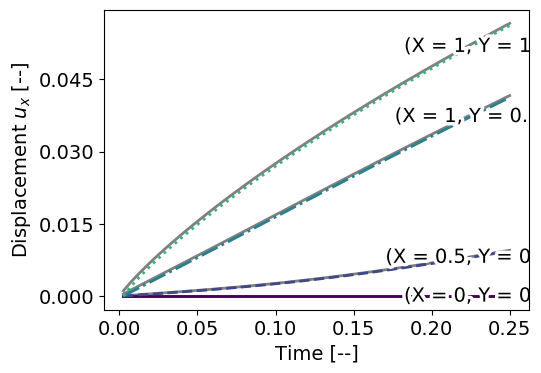

In [23]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Assuming ux_time, t, Nincr are already defined
# Initialize arrays to store displacement values for each point
uFOMx_00 = np.zeros(Nincr)
uFOMx_05 = np.zeros(Nincr)
uFOMx_11 = np.zeros(Nincr)
uFOMx_15 = np.zeros(Nincr)

uROMx_00 = np.zeros(Nincr)
uROMx_05 = np.zeros(Nincr)
uROMx_11 = np.zeros(Nincr)
uROMx_15 = np.zeros(Nincr)

# Extract displacement values for each point at each time step
for i in range(Nincr):
    uFOMx_00[i] = uFOMx_time[i](0, 0)
    uFOMx_05[i] = uFOMx_time[i](0.5, 0.5)
    uFOMx_11[i] = uFOMx_time[i](1, 1)
    uFOMx_15[i] = uFOMx_time[i](1, 0.5)
    
    uROMx_00[i] = uROMx_time[i](0, 0)
    uROMx_05[i] = uROMx_time[i](0.5, 0.5)
    uROMx_11[i] = uROMx_time[i](1, 1)
    uROMx_15[i] = uROMx_time[i](1, 0.5)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 10
points = np.arange(nPoints)

# Adjust the colormap range to 50% (blue to green portion of viridis)
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max()/2)  # Halving the effective range
colormap = cm.viridis

# Define different line styles for each plot
line_styles = ['-', '--', '-.', ':']

# Set the desired line width
line_width = 2  # Adjust this value as needed

# Plotting with increased line width
ax.plot(t[1:], uFOMx_00, color='grey', linewidth=line_width)
ax.plot(t[1:], uFOMx_05, color='grey', linewidth=line_width)
ax.plot(t[1:], uFOMx_15, color='grey', linewidth=line_width)
ax.plot(t[1:], uFOMx_11, color='grey', linewidth=line_width)

# Plotting with different line styles and restricted color range
line_labels = ['(X = 0, Y = 0)', '(X = 0.5, Y = 0.5)', '(X = 1, Y = 0.5)', '(X = 1, Y = 1)']
uROMx_all = [uROMx_00, uROMx_05, uROMx_15, uROMx_11]

for idx, (uROMx, style) in enumerate(zip(uROMx_all, line_styles)):
    ax.plot(t[1:], uROMx, style, color=colormap(normalize(points[idx])), label=line_labels[idx], linewidth=line_width)

# Label lines with custom positions for clarity
x_positions_for_labels = [0.8 + i * 0.05 for i in range(len(ax.get_lines()))]  # Slight adjustment for better label positioning
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14, xvals=x_positions_for_labels)

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
# ax.set_xlim([0, 0.25])
ax.set_ylabel('Displacement $u_x$ [--]', fontsize=14)
# ax.set_ylim([-0.01, 0.07])
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()  # Adjust the layout
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

# plt.savefig('results/ROM/Fig_2DFEM_disp_time_nestedPOD.pdf', bbox_inches='tight')
plt.show()

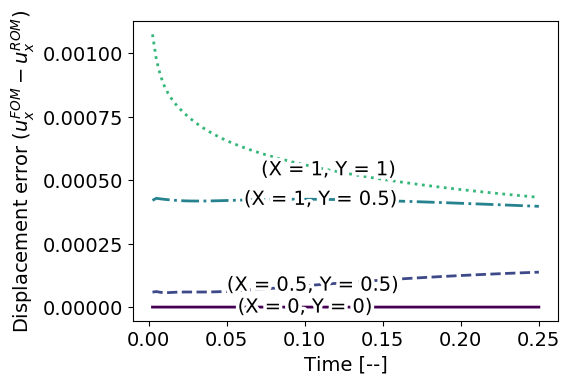

In [25]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Assuming ux_time, t, Nincr are already defined
# Initialize arrays to store displacement values for each point
uFOMx_00 = np.zeros(Nincr)
uFOMx_05 = np.zeros(Nincr)
uFOMx_11 = np.zeros(Nincr)
uFOMx_15 = np.zeros(Nincr)

uROMx_00 = np.zeros(Nincr)
uROMx_05 = np.zeros(Nincr)
uROMx_11 = np.zeros(Nincr)
uROMx_15 = np.zeros(Nincr)

# Extract displacement values for each point at each time step
for i in range(Nincr):
    uFOMx_00[i] = uFOMx_time[i](0, 0)
    uFOMx_05[i] = uFOMx_time[i](0.5, 0.5)
    uFOMx_11[i] = uFOMx_time[i](1, 1)
    uFOMx_15[i] = uFOMx_time[i](1, 0.5)
    
    uROMx_00[i] = uROMx_time[i](0, 0)
    uROMx_05[i] = uROMx_time[i](0.5, 0.5)
    uROMx_11[i] = uROMx_time[i](1, 1)
    uROMx_15[i] = uROMx_time[i](1, 0.5)

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 10
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max() * 0.5)  # Adjust range to half
colormap = cm.viridis

# Define different line styles for each plot
line_styles = ['-', '--', '-.', ':']

# Set the desired line width
line_width = 2  # Adjust this value as needed

# Plotting with increased line width and different line styles
line_labels = ['(X = 0, Y = 0)', '(X = 0.5, Y = 0.5)', '(X = 1, Y = 0.5)', '(X = 1, Y = 1)']
displacement_errors = [uFOMx_00 - uROMx_00, uFOMx_05 - uROMx_05, uFOMx_15 - uROMx_15, uFOMx_11 - uROMx_11]

for idx, (error, style) in enumerate(zip(displacement_errors, line_styles)):
    ax.plot(t[1:], error, style, color=colormap(normalize(points[idx])), label=line_labels[idx], linewidth=line_width)

# Label lines
# labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
# Label lines with custom positions for clarity
x_positions_for_labels = [0.1 + i * 0.005 for i in range(len(ax.get_lines()))]  # Slight adjustment for better label positioning
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14, xvals=x_positions_for_labels)


# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel(r'Displacement error $( u^{FOM}_x - u^{ROM}_x )$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()  # Adjust the layout
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

# plt.savefig('results/ROM/Fig_2DFEM_error_disp_time_nestedPOD.pdf', bbox_inches='tight')
plt.show()

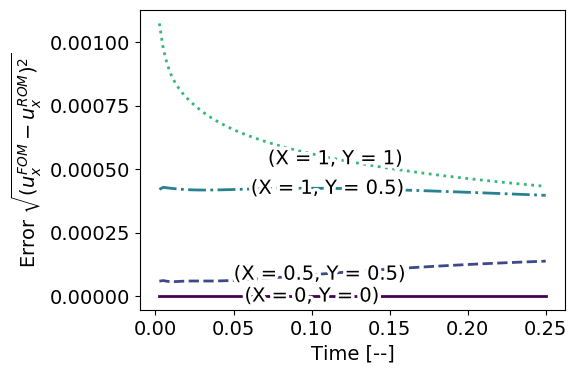

In [27]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Assuming ux_time, t, Nincr are already defined
# Initialize arrays to store displacement values for each point
uFOMx_00 = np.zeros(Nincr)
uFOMx_05 = np.zeros(Nincr)
uFOMx_11 = np.zeros(Nincr)
uFOMx_15 = np.zeros(Nincr)

uROMx_00 = np.zeros(Nincr)
uROMx_05 = np.zeros(Nincr)
uROMx_11 = np.zeros(Nincr)
uROMx_15 = np.zeros(Nincr)

# Extract displacement values for each point at each time step
for i in range(Nincr):
    uFOMx_00[i] = uFOMx_time[i](0, 0)
    uFOMx_05[i] = uFOMx_time[i](0.5, 0.5)
    uFOMx_11[i] = uFOMx_time[i](1, 1)
    uFOMx_15[i] = uFOMx_time[i](1, 0.5)
    
    uROMx_00[i] = uROMx_time[i](0, 0)
    uROMx_05[i] = uROMx_time[i](0.5, 0.5)
    uROMx_11[i] = uROMx_time[i](1, 1)
    uROMx_15[i] = uROMx_time[i](1, 0.5)
    
# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 10
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max() * 0.5)  # Adjust range to half
colormap = cm.viridis

# Define different line styles for each plot
line_styles = ['-', '--', '-.', ':']

# Set the desired line width
line_width = 2  # Adjust this value as needed

# Plotting with increased line width and different line styles
line_labels = ['(X = 0, Y = 0)', '(X = 0.5, Y = 0.5)', '(X = 1, Y = 0.5)', '(X = 1, Y = 1)']
squared_errors = [np.sqrt((uFOMx_00 - uROMx_00)**2), np.sqrt((uFOMx_05 - uROMx_05)**2), np.sqrt((uFOMx_15 - uROMx_15)**2), np.sqrt((uFOMx_11 - uROMx_11)**2)]

for idx, (error, style) in enumerate(zip(squared_errors, line_styles)):
    ax.plot(t[1:], error, style, color=colormap(normalize(points[idx])), label=line_labels[idx], linewidth=line_width)

# Label lines
# labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10)
# Label lines with custom positions for clarity
x_positions_for_labels = [0.1 + i * 0.005 for i in range(len(ax.get_lines()))]  # Slight adjustment for better label positioning
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14, xvals=x_positions_for_labels)

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel(r'Error $\sqrt{( u^{FOM}_x - u^{ROM}_x )^2}$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

# plt.savefig('results/ROM/Fig_2DFEM_squared_error_disp_time_nestedPOD.pdf', bbox_inches='tight')

plt.show()

/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=0.9). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=1.0). Clipping it into the allowed range.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/labellines/core.py:216: UserWarning: The value at position 3 in `xvals` is outside the range of its associated line (xmin=0.002500000000000009, xmax=0.25, xval=1.1). Clipping it into the allowed range.
  warnings.warn(


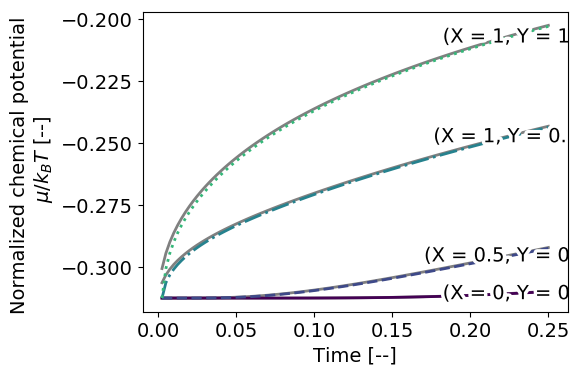

In [28]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Assuming ux_time, t, Nincr are already defined
# Initialize arrays to store displacement values for each point
µFOM_00 = np.zeros(Nincr)
µFOM_05 = np.zeros(Nincr)
µFOM_11 = np.zeros(Nincr)
µFOM_15 = np.zeros(Nincr)

µROM_00 = np.zeros(Nincr)
µROM_05 = np.zeros(Nincr)
µROM_11 = np.zeros(Nincr)
µROM_15 = np.zeros(Nincr)

# Extract displacement values for each point at each time step
for i in range(Nincr):
    µFOM_00[i] = µFOM_time[i](0, 0)
    µFOM_05[i] = µFOM_time[i](0.5, 0.5)
    µFOM_11[i] = µFOM_time[i](1, 1)
    µFOM_15[i] = µFOM_time[i](1, 0.5)
    
    µROM_00[i] = µROM_time[i](0, 0)
    µROM_05[i] = µROM_time[i](0.5, 0.5)
    µROM_11[i] = µROM_time[i](1, 1)
    µROM_15[i] = µROM_time[i](1, 0.5)
    
# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 10
points = np.arange(nPoints)

# Setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max() * 0.5)  # Adjust range to half
colormap = cm.viridis

# Set the desired line width
line_width = 2  # Adjust this value as needed

# Plotting with increased line width
ax.plot(t[1:], µFOM_00, color='grey', linewidth=line_width)
ax.plot(t[1:], µFOM_05, color='grey', linewidth=line_width)
ax.plot(t[1:], µFOM_15, color='grey', linewidth=line_width)
ax.plot(t[1:], µFOM_11, color='grey', linewidth=line_width)

# Plotting with different line styles for visibility
line_styles = ['-', '--', '-.', ':']
line_labels = ['(X = 0, Y = 0)', '(X = 0.5, Y = 0.5)', '(X = 1, Y = 0.5)', '(X = 1, Y = 1)']
µROM_values = [µROM_00, µROM_05, µROM_15, µROM_11]

for µROM, style, label, point in zip(µROM_values, line_styles, line_labels, points):
    ax.plot(t[1:], µROM, style, color=colormap(normalize(point)), label=label, linewidth=line_width)

# Label lines at custom x positions
x_positions_for_labels = [0.8 + i * 0.1 for i in range(len(ax.get_lines()))]
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14, xvals=x_positions_for_labels)

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel('Normalized chemical potential \n $\mu/k_B T$ [--]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

# plt.savefig('results/ROM/Fig_2DFEM_mu_time_nestedPOD.pdf', bbox_inches='tight')
plt.show()

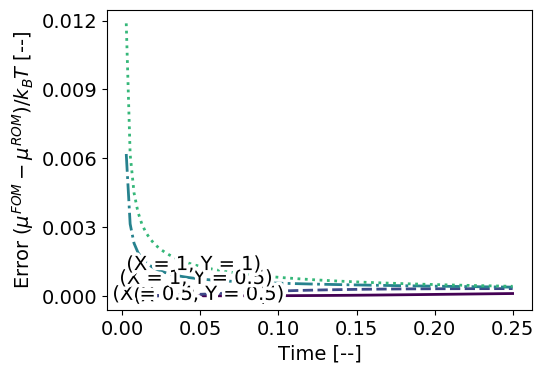

In [29]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Assuming ux_time, t, Nincr are already defined
# Initialize arrays to store displacement values for each point
µFOM_00 = np.zeros(Nincr)
µFOM_05 = np.zeros(Nincr)
µFOM_11 = np.zeros(Nincr)
µFOM_15 = np.zeros(Nincr)

µROM_00 = np.zeros(Nincr)
µROM_05 = np.zeros(Nincr)
µROM_11 = np.zeros(Nincr)
µROM_15 = np.zeros(Nincr)

# Extract displacement values for each point at each time step
for i in range(Nincr):
    µFOM_00[i] = µFOM_time[i](0, 0)
    µFOM_05[i] = µFOM_time[i](0.5, 0.5)
    µFOM_11[i] = µFOM_time[i](1, 1)
    µFOM_15[i] = µFOM_time[i](1, 0.5)
    
    µROM_00[i] = µROM_time[i](0, 0)
    µROM_05[i] = µROM_time[i](0.5, 0.5)
    µROM_11[i] = µROM_time[i](1, 1)
    µROM_15[i] = µROM_time[i](1, 0.5)

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 10
points = np.arange(nPoints)

# Adjusting the normalization to cover only half the color range of viridis
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max() * 0.5)
colormap = cm.viridis

# Set the desired line width
line_width = 2  # Adjust this value as needed

# Define different line styles for each plot
line_styles = ['-', '--', '-.', ':']
labels = ['(X = 0, Y = 0)', '(X = 0.5, Y = 0.5)', '(X = 1, Y = 0.5)', '(X = 1, Y = 1)']
errors = [µFOM_00 - µROM_00, µFOM_05 - µROM_05, µFOM_15 - µROM_15, µFOM_11 - µROM_11]

# Plotting each line with a different style
for err, style, label, pt in zip(errors, line_styles, labels, points):
    ax.plot(t[1:], err, style, color=colormap(normalize(pt)), label=label, linewidth=line_width)

# Label lines
# labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10, xvals=[0.8 + i * 0.05 for i in range(len(ax.get_lines()))])
# Label lines with custom positions for clarity
x_positions_for_labels = [0.05 - i * 0.0015 for i in range(len(ax.get_lines()))]  # Slight adjustment for better label positioning
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14, xvals=x_positions_for_labels)

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel(r'Error $(\mu^{FOM} - \mu^{ROM})/k_B T$ [--]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()  # Adjust the layout
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

# plt.savefig('results/ROM/Fig_2DFEM_error_mu_time_nestedPOD.pdf', bbox_inches='tight')
plt.show()

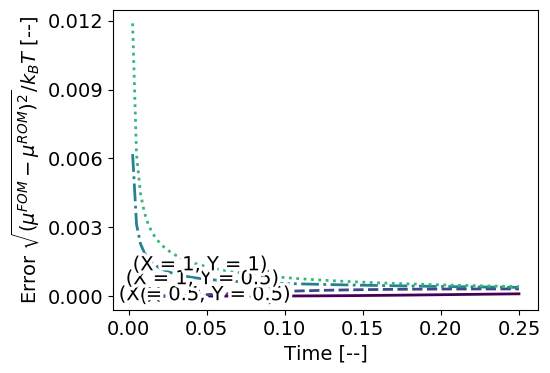

In [30]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from labellines import labelLines
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

# Assuming ux_time, t, Nincr are already defined
# Initialize arrays to store displacement values for each point
µFOM_00 = np.zeros(Nincr)
µFOM_05 = np.zeros(Nincr)
µFOM_11 = np.zeros(Nincr)
µFOM_15 = np.zeros(Nincr)

µROM_00 = np.zeros(Nincr)
µROM_05 = np.zeros(Nincr)
µROM_11 = np.zeros(Nincr)
µROM_15 = np.zeros(Nincr)

# Extract displacement values for each point at each time step
for i in range(Nincr):
    µFOM_00[i] = µFOM_time[i](0, 0)
    µFOM_05[i] = µFOM_time[i](0.5, 0.5)
    µFOM_11[i] = µFOM_time[i](1, 1)
    µFOM_15[i] = µFOM_time[i](1, 0.5)
    
    µROM_00[i] = µROM_time[i](0, 0)
    µROM_05[i] = µROM_time[i](0.5, 0.5)
    µROM_11[i] = µROM_time[i](1, 1)
    µROM_15[i] = µROM_time[i](1, 0.5)

# Setup figure and axis
fig, ax = plt.subplots(figsize=(5,4))

# Define the range of values for normalization
nPoints = 10
points = np.arange(nPoints)

# Adjust the normalization to cover only half the color range of viridis
normalize = mcolors.Normalize(vmin=points.min(), vmax=points.max() * 0.5)
colormap = cm.viridis

# Set the desired line width
line_width = 2  # Adjust this value as needed

# Define different line styles for each plot for visibility
line_styles = ['-', '--', '-.', ':']
labels = ['(X = 0, Y = 0)', '(X = 0.5, Y = 0.5)', '(X = 1, Y = 0.5)', '(X = 1, Y = 1)']
µ_errors = [np.sqrt((µFOM_00 - µROM_00)**2), np.sqrt((µFOM_05 - µROM_05)**2), np.sqrt((µFOM_15 - µROM_15)**2), np.sqrt((µFOM_11 - µROM_11)**2)]

# Plotting each line with a different style
for err, style, label, pt in zip(µ_errors, line_styles, labels, points):
    ax.plot(t[1:], err, style, color=colormap(normalize(pt)), label=label, linewidth=line_width)

# Label lines at custom x positions to improve readability
# labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=10, xvals=[0.8 + i * 0.1 for i in range(len(ax.get_lines()))])
# Label lines with custom positions for clarity
x_positions_for_labels = [0.05 - i * 0.0015 for i in range(len(ax.get_lines()))]  # Slight adjustment for better label positioning
labelLines(ax.get_lines(), align=False, zorder=2.5, color="k", fontsize=14, xvals=x_positions_for_labels)

# Set labels and other properties
ax.set_xlabel('Time [--]', fontsize=14)
ax.set_ylabel(r'Error $\sqrt{(\mu^{FOM} - \mu^{ROM})^2}/k_B T$ [--]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)

# Set the maximum number of ticks for x and y axes
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust number of bins as needed
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust number of bins as needed

# Adjust layout
plt.tight_layout()  # Adjust the layout
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.95, top=0.9)

# plt.savefig('results/ROM/Fig_2DFEM_squared_error_mu_time_nestedPOD.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from scipy.optimize import minimize

# Assuming S, reduced_problem, µFOM_time, uFOM_time, and all necessary imports and setups are defined

def objective(online_mu):
    reduced_problem.set_mu(tuple(online_mu))
    reduced_solution = reduced_problem.solve()

    # Specify the two time instances for optimization
    # time_instances = [5, 9, 14, 24] # x: [ 1.635e+03  3.974e+03]
    time_instances = [14, 24] # TVD => x: [ 1.631e+03  4.025e+03], L2 => x: [ 1.587e+03  3.916e+03]
    # time_instances = [14, 19, 24] # TVD =>  x: [ 1.643e+03  4.033e+03]
    # time_instances = [24] # TVD => x: [ 1.634e+03  4.041e+03], L2 => x: [ 1.613e+03  3.989e+03]
    total_tvd_approximation = 0  # Initialize total TVD approximation
    total_relative_L2_error = 0

    for time_instance in time_instances:
        reduced_solution_at_time_instance = reduced_solution[time_instance]
        reconstructed_reduced_solution_at_time_instance = reduced_problem.basis_functions * reduced_solution_at_time_instance
        (uROM, µROM) = split(reconstructed_reduced_solution_at_time_instance)

        # Create functions for µ and displacement components in the reduced basis
        µ_reduced_func = project(µROM, S.sub(1).collapse())
        displacement_magnitude_MOR = sqrt(inner(uROM, uROM))
        dips_mag_MOR = project(displacement_magnitude_MOR, S.sub(1).collapse())

        # Compute errors for this time instance
        µ_full_func = Function(S.sub(1).collapse())
        µ_full_func.assign(µFOM_time[time_instance])
        error_µ = Function(S.sub(1).collapse())
        error_µ.vector()[:] = abs(µ_full_func.vector()[:] - µ_reduced_func.vector()[:]) 

        dips_mag_FOM = project(sqrt(inner(uFOM_time[time_instance], uFOM_time[time_instance])), S.sub(1).collapse())
        error_u = Function(S.sub(1).collapse())
        error_u.vector()[:] = abs(dips_mag_FOM.vector()[:] - dips_mag_MOR.vector()[:])

    #     # Calculate L2 norm of the errors
    #     L2_error_µ = np.linalg.norm(error_µ.vector()[:], 2)
    #     L2_error_u = np.linalg.norm(error_u.vector()[:], 2)

    # # Objective is the sum of L2 norms
    # return 10*L2_error_µ + L2_error_u
    
        mean_data_µ = np.mean(µ_full_func.vector()[:])
        mean_data_u = np.mean(dips_mag_FOM.vector()[:])

        relative_L2_error_µ = np.linalg.norm(error_µ.vector()[:]) / np.linalg.norm(mean_data_µ)
        relative_L2_error_u = np.linalg.norm(error_u.vector()[:]) / np.linalg.norm(mean_data_u)

        total_relative_L2_error += 10*relative_L2_error_µ + relative_L2_error_u

    return total_relative_L2_error

    # #     # Update the total TVD approximation by adding the sum of absolute differences for this time instance
    #     total_tvd_approximation += np.sum(error_µ.vector()[:]) + np.sum(error_u.vector()[:])

    # # Return the total TVD approximation as the objective value
    # return total_tvd_approximation

# Initial guess for online_mu
# initial_guess = [1558, 4000]
# initial_guess = [1500, 4050]
# initial_guess = [1600, 4050]
initial_guess = [1800,3800]

# Bound constraints for online_mu, if any, e.g., [(1550, 1560), (3900, 4100)]
bounds = [(1000, 2000), (2000, 6000)]  # Adjust based on actual constraints

# Initialize a global variable to track the iteration count
iteration_count = 0

# Define a callback function that prints the current state
def callback_func(xk):
    global iteration_count
    iteration_count += 1
    print(f"Iteration {iteration_count}: xk = {xk}")

# Perform the optimization with the callback function
# result = minimize(objective, initial_guess, method='BFGS', callback=callback_func)
result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B', callback=callback_func)#, options={'maxls':30})

print("Optimization result:", result)

# # Perform the optimization
# result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')

# print("Optimization result:", result)

Iteration 1: xk = [1799.97854707 3800.00429172]
Iteration 2: xk = [1615.30410031 3903.75419016]
Iteration 3: xk = [1606.55841058 3907.26098282]
Iteration 4: xk = [1602.74313364 3909.2314415 ]
Iteration 5: xk = [1592.30282936 3913.69869089]
Iteration 6: xk = [1589.52352422 3914.77414229]
Iteration 7: xk = [1589.47052738 3914.7832709 ]
Iteration 8: xk = [1589.34625857 3914.85597629]
Iteration 9: xk = [1589.34480109 3914.85543135]
Optimization result:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 112.37967876870115
        x: [ 1.589e+03  3.915e+03]
      nit: 9
      jac: [ 2.530e-04 -2.075e-04]
     nfev: 117
     njev: 39
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
